In [1]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()
import tensorflow.compat.v1.keras.backend as K
from __future__ import print_function
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import pickle

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
pickle_in = open('/content/drive/MyDrive/Leukocyty/X_train.pickle', 'rb')
X_train = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/Leukocyty/y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/Leukocyty/X_test.pickle', 'rb')
X_test = pickle.load(pickle_in)
pickle_in = open('/content/drive/MyDrive/Leukocyty/y_test.pickle', 'rb')
y_test = pickle.load(pickle_in)

In [3]:
batch_size = 32
num_classes = 4
epochs = 20

In [4]:
img_rows, img_cols = 224, 224

In [5]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [6]:
print(y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(1597, 4)
(1597, 224, 224, 3)
(193, 224, 224, 3)
(193, 4)


In [7]:
K.image_data_format()
#if K.image_data_format() == 'channels_first':
#    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
#    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
#    input_shape = (1, img_rows, img_cols)
#else:
#    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
#    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
#    input_shape = (img_rows, img_cols, 1)

'channels_last'

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (1597, 224, 224, 3)
1597 train samples
193 test samples


In [9]:
input_shape = (img_rows, img_cols, 3)

In [10]:
vgg = VGG16(input_shape = input_shape, weights='imagenet', include_top=False)

In [11]:
for layeer in vgg.layers:
  layeer.trainable = False

x = Flatten()(vgg.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=predictions)
opt = Adam(lr=0.0004)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [12]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 1597 samples, validate on 193 samples
Epoch 1/20
1597/1597 [==============================] - ETA: 0s - loss: 9.0153 - acc: 0.4214WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
1597/1597 [==============================] - 8s 5ms/sample - loss: 9.0153 - acc: 0.4214 - val_loss: 7.3118 - val_acc: 0.5285
Epoch 2/20
1597/1597 [==============================] - 7s 4ms/sample - loss: 6.7466 - acc: 0.5466 - val_loss: 6.7115 - val_acc: 0.5492
Epoch 3/20
1597/1597 [==============================] - 7s 4ms/sample - loss: 5.2993 - acc: 0.6531 - val_loss: 3.9633 - val_acc: 0.7254
Epoch 4/20
1597/1597 [==============================] - 7s 4ms/sample - loss: 3.5715 - acc: 0.7451 - val_loss:

In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.8832940747092811
Test accuracy: 0.91709846
CNN Error: 8.29%


In [ ]:
pip install shap

In [15]:
import shap

In [16]:
to_explain = X_test[[113, 22, 65, 178,]]
to_explain.shape

(4, 224, 224, 3)

In [17]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [18]:
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X_test, 7),
    local_smoothing=0 # std dev of smoothing noise
)

shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=4)

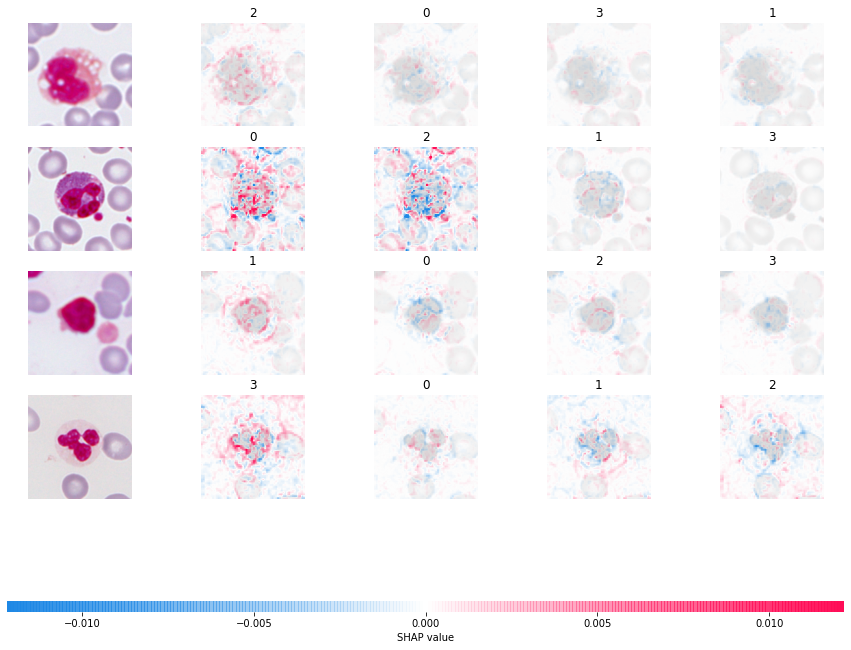

In [19]:
shap.image_plot(shap_values, to_explain, indexes)
#'EOSINOPHIL':0,'LYMPHOCYTE':1,'MONOCYTE':2, 'NEUTROPHIL':3

In [20]:
background = X_train[np.random.choice(X_train.shape[0], 4, replace=False)]

In [21]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(X_test[113:117])

keras is no longer supported, please use tf.keras instead.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


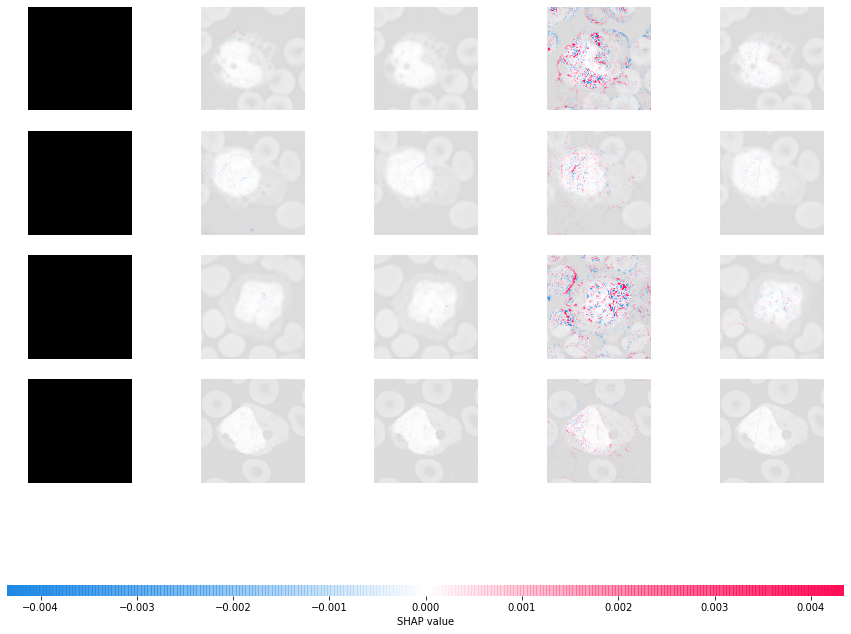

In [22]:
shap.image_plot(shap_values, -X_test[113:117])